# Наумкин Владимир, С01-119.

## Задача 4. Вариационный автокодировщик.

### Подключим библиотеки

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

### Уберём предупреждения

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Зададим устройство исполнения кода (вычисления провожу на своём ПК)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Синтетическая выборка кластеров из гауссиан

In [4]:
def gauss_clusters(number_clusters = 3, number_samples = 5000, vector_size = 8):
    clusters = []
    for i in range(number_clusters):
        mu = np.random.uniform(-10, 10, vector_size)
        sigma = np.eye(vector_size)
        cluster = np.random.multivariate_normal(mu, sigma, number_samples)
        clusters.extend(cluster)
    data = torch.Tensor(clusters)
    train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 77)
    return TensorDataset(train_data, train_data), TensorDataset(test_data, test_data)

In [5]:
def plot(xy):
    plt.figure(figsize=(8, 6))
    plt.hist2d(xy[:, 0], xy[:, 1], bins = 50)
    plt.show()

### Функция проверки качества модели

In [6]:
def check_model(batch_size, dataset, model, loss_function):
    model.eval()
    batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size)
    test_loss = 0
    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(model.device)
        y_batch = y_batch.to(model.device)
        with torch.no_grad():
            output = model(x_batch)
        test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)
    test_loss /= len(dataset)
    print(f'loss: {test_loss}')
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    data, _ = next(iter(dataloader))
    data = data.numpy()
    plot(data)
    data = model.generate_samples(5000).cpu().data.numpy()
    plot(data)
    return test_loss

### Код для обучения модели

In [7]:
def train_on_batch(model, x_batch, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(x_batch.to(model.device))
    loss.backward()
    optimizer.step()
    return loss.cpu().item()

In [8]:
def train_epoch(train_generator, model, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, _) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, optimizer)
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    return epoch_loss/total

In [9]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):
    optima = optimizer(model.parameters(), lr=lr)
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    optimizer=optima, 
                    callback=callback)
        iterations.set_postfix({'train epoch loss': epoch_loss})

### Отслеживание обучения

In [10]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 300, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.dataset = dataset
    def forward(self, model, loss):
        model.eval()
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        if self.step % self.delimeter == 0:
            model.eval()
            batch_generator = torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size)
            test_loss = 0
            for it, (x_batch, _) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                output = model(x_batch)
                test_loss += self.loss_function(output, x_batch).cpu().item()*len(x_batch)
            test_loss /= len(self.dataset)
            print(f"\t\tstep={self.step}, train_loss={loss}, val_loss={test_loss}")
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
    def __call__(self, model, loss):
        return self.forward(model, loss)

## Модель вариационного автокодировщика

В отличие от 16 семинара надо восстановить нормальное распределение x. То есть изменится функция q_x, в init добавится proposal для x (это всё вместо generative network), в loss и generate_samples x тоже будет нормальным, поменяется также log_likelyhood и forward.

In [11]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    def __init__(self, latent_dim, input_dim, hidden_dim=1000):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU()
        )
        self.proposal_mu_z = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma_z = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_x = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU()
        )
        self.proposal_mu_x = torch.nn.Linear(hidden_dim, self.input_dim)
        self.proposal_sigma_x = torch.nn.Linear(hidden_dim, self.input_dim)
    def q_z(self, x):
        x = x.to(self.device)
        proposal = self.proposal_z(x)
        mu = self.proposal_mu_z(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma_z(proposal))
        return mu, sigma
    def p_z(self, num_samples):
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma
    def sample_z(self, distr, num_samples=1):
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)
        batch_size = mu.shape[0]
        bias = mu.view([batch_size, 1, self.latent_dim])
        epsilon = torch.randn([batch_size, num_samples, self.latent_dim], requires_grad=True, device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])
        return bias + epsilon * scale
    def q_x(self, z):
        z = z.to(self.device)
        proposal = self.proposal_x(z)
        mu = self.proposal_mu_x(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma_x(proposal))
        return mu, sigma
    def loss(self, batch_x):
        batch_x = batch_x.to(self.device)
        batch_size = batch_x.shape[0]
        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)
        z = self.sample_z(propos_distr)
        mu, sigma = self.q_x(z)
        epsilon = torch.randn([batch_size, z.shape[1], self.input_dim], requires_grad=True, device=self.device)
        pred_x = mu + sigma * epsilon
        expectation = torch.mean(self.log_mean_exp(self.log_likelihood(batch_x, pred_x)), dim=0)
        divergence = self.divergence_KL_normal(propos_distr, pri_distr)
        return -1 * torch.mean(expectation - divergence, dim=0)
    def generate_samples(self, num_samples):
        distr_z = self.p_z(num_samples=1)
        z = self.sample_z(distr_z, num_samples=num_samples)
        mu, sigma = self.q_x(z)
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)
        bias = mu.view([num_samples, self.input_dim])
        epsilon = torch.randn([num_samples, self.input_dim], requires_grad=True, device=self.device)
        scale = sigma.view([num_samples, self.input_dim])
        return (mu + sigma * epsilon)[0]
    @staticmethod
    def log_pdf_normal(distr, samples):
        mu, sigma = distr
        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]
        f1 = torch.sum(((samples - mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3
    @staticmethod
    def log_likelihood(x_true, x_distr):
        return -torch.sum((x_true.view(x_distr.shape[0], 1, x_distr.shape[2]) - x_distr) ** 2, dim=2)
    @staticmethod
    def log_mean_exp(data):
        return torch.logsumexp(data, dim=-1) - torch.log(torch.Tensor([data.shape[-1]]).to(data.device))
    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr
        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - 2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL
    def forward(self, x):
        mu, _ = self.q_x(self.sample_z(self.q_z(x)))
        return mu

### Обучение модели

Loss для обучения встроен в саму модель, по сути это MSELoss, используемый для проверки качества.

In [13]:
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()

Перебираемые параметры модели:

In [14]:
latent_dim_params = [3, 10, 25] # размер скрытого представления
input_dim_params = [10, 25, 50] # размер исходного пространства
relationship_params = [0.5, 1, 2] # отношение размера скрытого представления к размеру исходного пространства
hidden_dim_params = [250, 500, 1000] # размер слоя нейросети (см. init в классе VAE)

latent_dim = 3
loss: 32.138988444010415


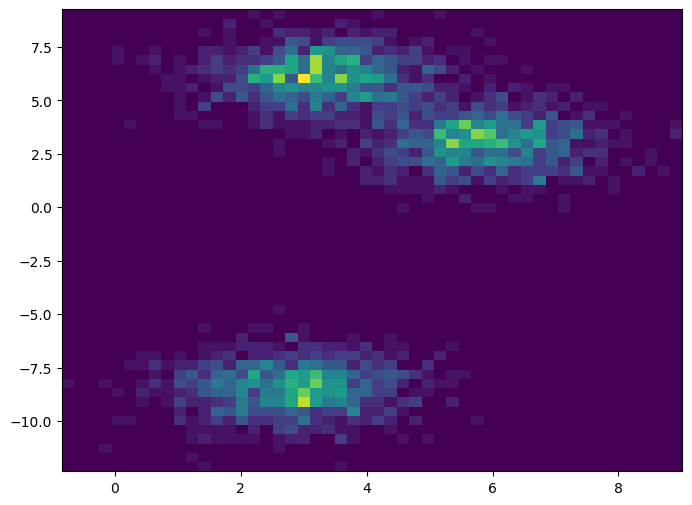

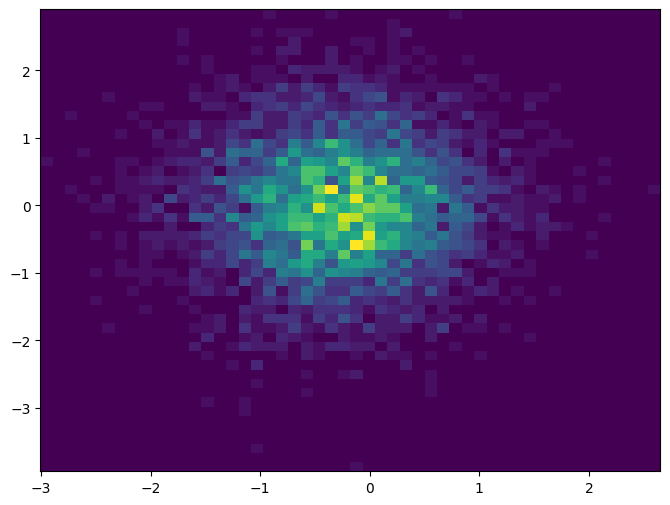

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=33.479331970214844, val_loss=35.84513677978516


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=32.7160530090332, val_loss=36.40437199910482


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=32.264610290527344, val_loss=36.849195658365886


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=31.73105812072754, val_loss=37.28120738728841


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=30.50762367248535, val_loss=36.65226433308919


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=31.782373428344727, val_loss=36.45449552408854


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=31.17470932006836, val_loss=37.33651190185547


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=28.964563369750977, val_loss=36.42460017903646


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=29.97115707397461, val_loss=37.21218930053711


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=30.033864974975586, val_loss=36.60013627115885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.303312301635742, val_loss=36.44601663208008


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=29.37626075744629, val_loss=36.35430692545573


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=29.478355407714844, val_loss=36.49603525797526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=29.851734161376953, val_loss=36.34096245320638


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=29.61365509033203, val_loss=36.26903766886393


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=29.484867095947266, val_loss=36.64360998535156


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=29.897008895874023, val_loss=36.733518280029294


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=28.037076950073242, val_loss=36.00012768554687


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=27.881832122802734, val_loss=37.06626176961263


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=29.577470779418945, val_loss=36.56705998738607


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=29.215105056762695, val_loss=36.0397374979655


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=28.49221420288086, val_loss=36.85100713094076


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=28.64180564880371, val_loss=36.48409840901693


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=27.403072357177734, val_loss=36.73166275024414


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=28.55742645263672, val_loss=36.720841125488285


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=28.32573890686035, val_loss=36.728446736653645


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=29.235637664794922, val_loss=36.21805167643229


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=28.934125900268555, val_loss=36.705702463785805


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=29.587310791015625, val_loss=36.908249348958336


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=28.474624633789062, val_loss=36.54179677327474


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=27.94547462463379, val_loss=36.57519934082031


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=27.7104549407959, val_loss=36.72513716634115


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=27.002897262573242, val_loss=36.58299255371094


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=28.059080123901367, val_loss=36.70545960489909


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=28.275493621826172, val_loss=36.38993077596029


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=27.593294143676758, val_loss=36.573969217936195


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.545833587646484, val_loss=36.47104023234049


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=27.814546585083008, val_loss=36.34918615722656


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=26.459402084350586, val_loss=36.78705162556966


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=28.232669830322266, val_loss=36.49275728352865


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=28.587547302246094, val_loss=36.78912915039062


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=27.984600067138672, val_loss=36.48113009643555


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=28.723228454589844, val_loss=36.61743188476562


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=27.812891006469727, val_loss=36.439270985921226


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=28.850406646728516, val_loss=36.69780172729492


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=26.4643497467041, val_loss=36.23825225830078


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=28.480844497680664, val_loss=36.6242893371582


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=27.339611053466797, val_loss=36.54176450602213


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=26.734844207763672, val_loss=36.55794841512044


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=27.33167266845703, val_loss=36.45837989298503


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=26.856121063232422, val_loss=36.5110156656901


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=28.156362533569336, val_loss=36.768935953776044


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=26.692760467529297, val_loss=36.60422859700521


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=27.752967834472656, val_loss=36.41867970784505


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=28.132160186767578, val_loss=36.4396928507487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=26.544857025146484, val_loss=36.7773398844401


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=26.48200798034668, val_loss=36.52384903971354


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=27.256107330322266, val_loss=36.93107363891602


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=27.834369659423828, val_loss=36.61972514851888


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=25.767353057861328, val_loss=36.820726959228516


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=25.365205764770508, val_loss=36.8287041015625


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=30.06020164489746, val_loss=36.936929005940755


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 36.54709649658203


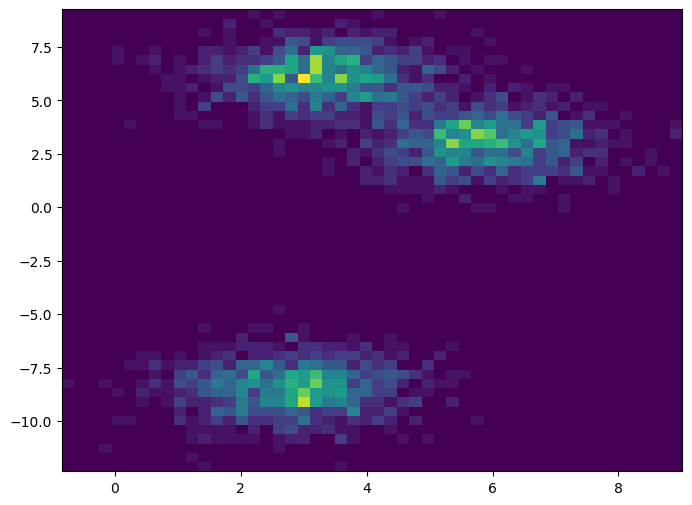

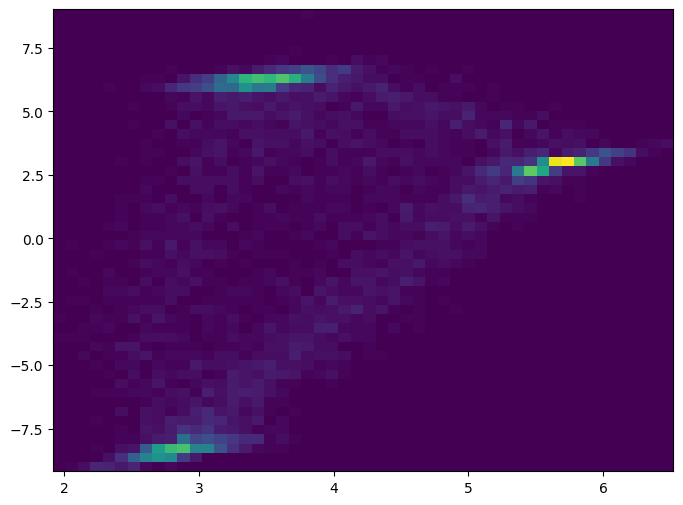

latent_dim = 10
loss: 32.20010141499837


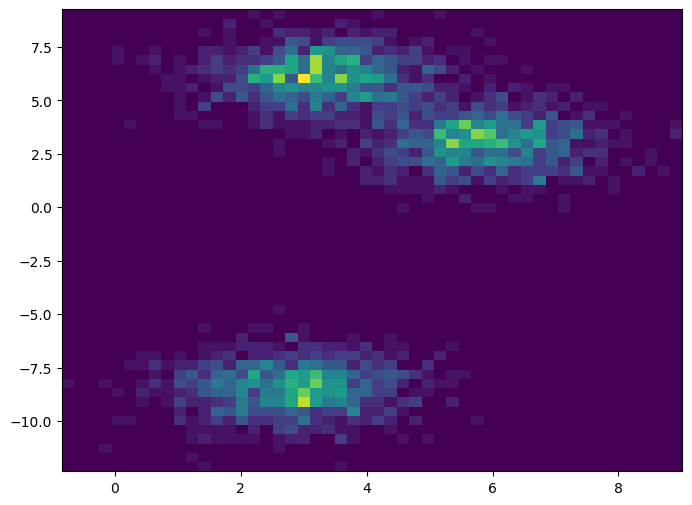

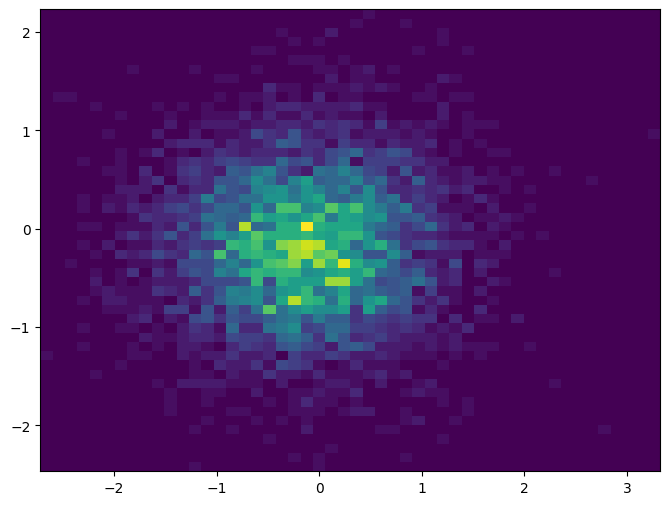

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=37.44654846191406, val_loss=35.87658142089844


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=34.18451690673828, val_loss=36.581889251708986


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=34.074058532714844, val_loss=38.05366081746419


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=31.54393768310547, val_loss=37.21082380167643


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=32.294273376464844, val_loss=36.513440083821614


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=32.397743225097656, val_loss=36.93666778564453


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=31.362628936767578, val_loss=36.92738564046224


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=28.936552047729492, val_loss=37.507556905110675


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=29.454036712646484, val_loss=36.1004651184082


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=28.54566764831543, val_loss=36.31397764078776


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.702890396118164, val_loss=36.60776864624023


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=30.11256980895996, val_loss=36.50175272623698


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=29.02099609375, val_loss=36.880053894042966


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=29.092647552490234, val_loss=37.35166475423177


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=29.765106201171875, val_loss=36.912112375895184


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=28.66637420654297, val_loss=36.64287896728516


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=29.35482406616211, val_loss=37.148307759602865


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=28.537029266357422, val_loss=36.35415221150716


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=28.51063346862793, val_loss=36.957577239990236


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=29.062206268310547, val_loss=36.94353702799479


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=27.034372329711914, val_loss=37.22511936442057


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=28.84219741821289, val_loss=36.965009724934895


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=27.447040557861328, val_loss=36.89921056111654


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=28.29145050048828, val_loss=36.62715987141927


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=27.77704620361328, val_loss=36.55438232421875


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=27.451295852661133, val_loss=36.8047197265625


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=27.564903259277344, val_loss=37.23570287068685


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=27.843002319335938, val_loss=36.794944691975914


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=28.411632537841797, val_loss=36.903425303141276


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=27.630359649658203, val_loss=36.314530466715496


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=28.646373748779297, val_loss=36.83632089233399


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=27.607423782348633, val_loss=36.71098940022787


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=27.20969009399414, val_loss=36.39385865275065


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=26.738391876220703, val_loss=37.32683620198568


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=27.18208122253418, val_loss=36.66924160766602


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=26.03580093383789, val_loss=36.83557722981771


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.20363426208496, val_loss=36.701463439941406


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=26.79343032836914, val_loss=36.78154098510742


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=26.10120964050293, val_loss=36.73415787760417


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=26.443540573120117, val_loss=36.479303619384766


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=27.138729095458984, val_loss=36.51709766642253


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=26.0469913482666, val_loss=36.746568939208984


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=26.694805145263672, val_loss=36.72353474934896


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=26.318317413330078, val_loss=36.7166330464681


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=25.901735305786133, val_loss=36.330037638346354


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=26.5097713470459, val_loss=37.0326948445638


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=26.743215560913086, val_loss=37.20265887451172


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=25.43497657775879, val_loss=37.005531514485675


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=25.21582794189453, val_loss=36.827839599609376


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=28.348268508911133, val_loss=36.77547888183594


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=25.103914260864258, val_loss=36.62567181396484


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=27.996307373046875, val_loss=36.8955366007487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=27.23031234741211, val_loss=36.67529260253906


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=26.725908279418945, val_loss=36.693025380452475


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=25.909591674804688, val_loss=36.560030222574866


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=27.077709197998047, val_loss=36.595039794921874


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=26.475358963012695, val_loss=36.798138712565105


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=24.970447540283203, val_loss=36.75374575805664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=25.83838653564453, val_loss=37.1630695292155


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=27.06679916381836, val_loss=36.779690633138024


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=26.107547760009766, val_loss=36.69378653971354


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=26.437461853027344, val_loss=36.9472737121582


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 37.18965403238932


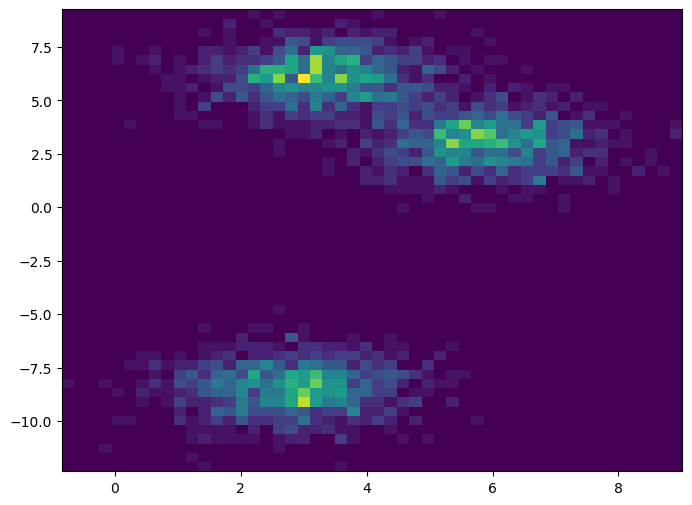

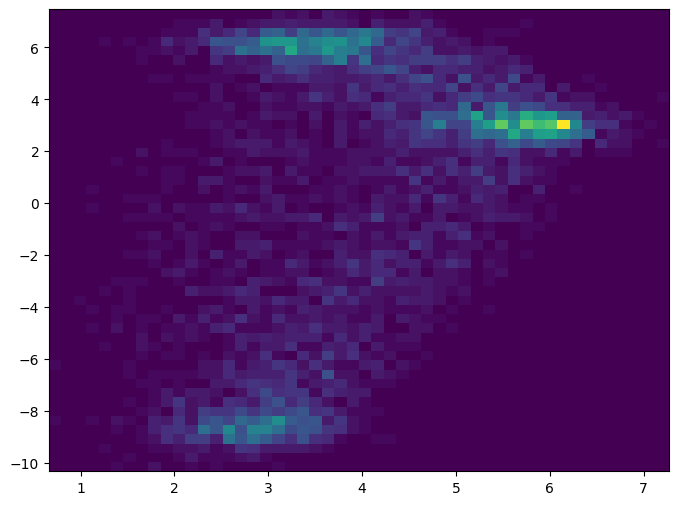

latent_dim = 25
loss: 32.47569267781576


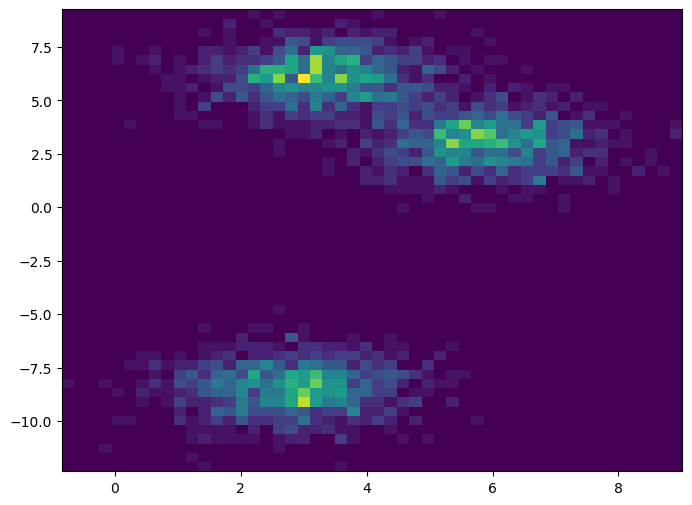

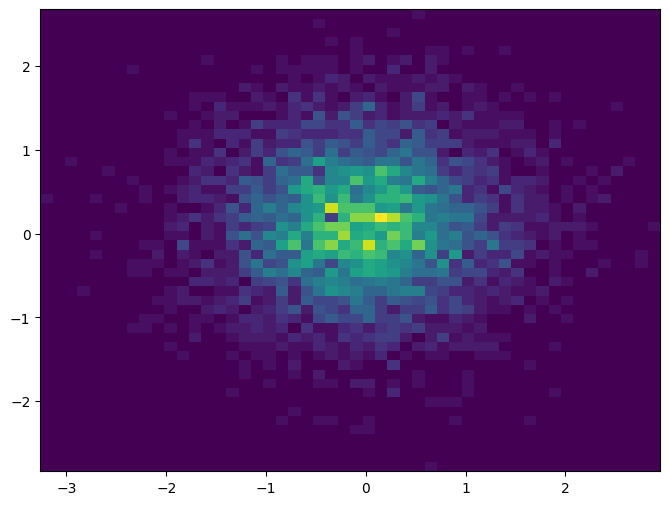

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=41.33966827392578, val_loss=36.12861759440104


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=36.180728912353516, val_loss=36.55096446736653


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=32.597347259521484, val_loss=36.66073213704427


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=30.545501708984375, val_loss=37.58191563924154


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=29.44967269897461, val_loss=37.72334044392904


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=29.26664161682129, val_loss=36.471021016438804


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=29.91770362854004, val_loss=37.4701312866211


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=30.594669342041016, val_loss=36.78036123657227


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=28.137073516845703, val_loss=37.32795167032877


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=27.477819442749023, val_loss=37.03803161621094


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=27.174022674560547, val_loss=35.8043910929362


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=28.504772186279297, val_loss=37.58370622762044


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=26.274723052978516, val_loss=36.27673946126302


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=26.057048797607422, val_loss=37.59409526570638


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=26.87368392944336, val_loss=37.13393152872721


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=27.34540557861328, val_loss=37.52057043457031


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=27.50372314453125, val_loss=37.19908336385091


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=25.534812927246094, val_loss=37.605817555745446


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=26.438764572143555, val_loss=37.38480040486654


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=26.11229133605957, val_loss=37.27740674845378


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=26.175622940063477, val_loss=36.644551981608075


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=26.757368087768555, val_loss=37.15415012613932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=26.438796997070312, val_loss=36.86373147583008


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=27.189659118652344, val_loss=36.17218704223633


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=27.453258514404297, val_loss=37.281077412923175


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=26.603591918945312, val_loss=37.77399619547526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=26.362529754638672, val_loss=36.935875569661455


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=25.96355628967285, val_loss=37.18315323893229


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=26.51970672607422, val_loss=38.03082104492187


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=26.58147430419922, val_loss=37.1828881632487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=27.49170684814453, val_loss=37.47119908650716


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=26.27522850036621, val_loss=36.81936368815104


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=25.743927001953125, val_loss=36.72627129109701


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=25.610294342041016, val_loss=36.78653688557943


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=26.379356384277344, val_loss=36.306109842936195


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=25.192462921142578, val_loss=37.28103287760417


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=26.240066528320312, val_loss=37.46001069132487


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=24.605976104736328, val_loss=37.11101330566406


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=25.918588638305664, val_loss=36.826180867513024


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=25.5489501953125, val_loss=36.92098907470703


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=25.028602600097656, val_loss=37.026686594645184


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=25.608495712280273, val_loss=36.90331280517578


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=25.629558563232422, val_loss=36.72668430582682


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=26.28904151916504, val_loss=37.11347981770833


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=25.346887588500977, val_loss=37.18054370117188


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=25.35186004638672, val_loss=37.35006629435221


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=25.669967651367188, val_loss=37.27943460083008


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=25.559547424316406, val_loss=36.86027551269531


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=25.750911712646484, val_loss=37.3110139058431


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=25.054702758789062, val_loss=36.43124569702148


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=25.52969741821289, val_loss=37.42077347819011


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=24.901222229003906, val_loss=36.76204433186849


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=25.426082611083984, val_loss=37.051553415934244


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=24.473560333251953, val_loss=37.23557190958659


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=24.833740234375, val_loss=37.1843823445638


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=24.98610496520996, val_loss=37.44018889363607


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=25.506258010864258, val_loss=36.86977942911784


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=25.336793899536133, val_loss=36.908160919189456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=23.967193603515625, val_loss=36.818206848144534


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=26.466022491455078, val_loss=36.96209005737305


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=25.4426326751709, val_loss=36.74116176350911


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=24.835834503173828, val_loss=36.84884280395508


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 37.010673919677735


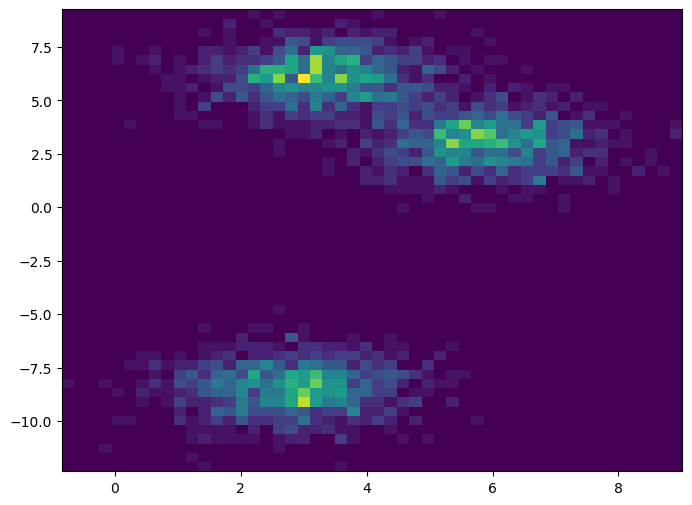

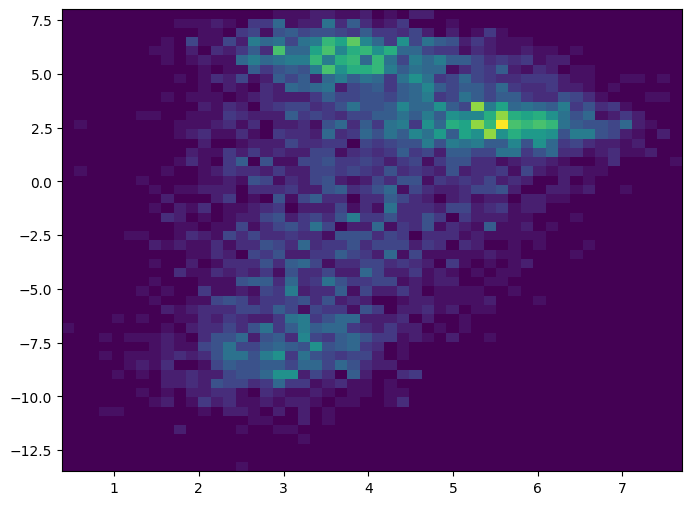

In [15]:
train_dataset, test_dataset = gauss_clusters(number_clusters=3, number_samples=5000, vector_size=25)
for latent_dim in latent_dim_params:
    print(f'latent_dim = {latent_dim}')
    model = VAE(latent_dim, input_dim=25, hidden_dim=1000)
    model.to(device)
    writer = SummaryWriter(log_dir = f'tensorboard4/latent_dim_{latent_dim}')
    call = callback(writer, test_dataset, loss_function)
    check_model(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100,
        batch_size=64,
        dataset=train_dataset,
        model=model,
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check_model(64, test_dataset, model, loss_function)

input_dim = 10
loss: 40.446253611246746


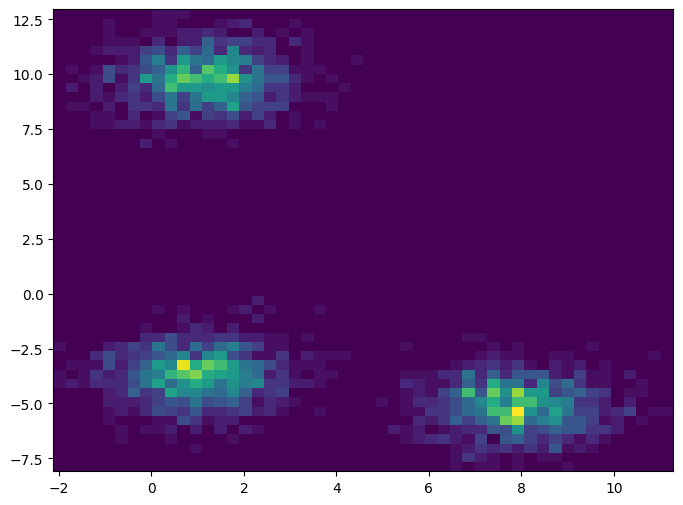

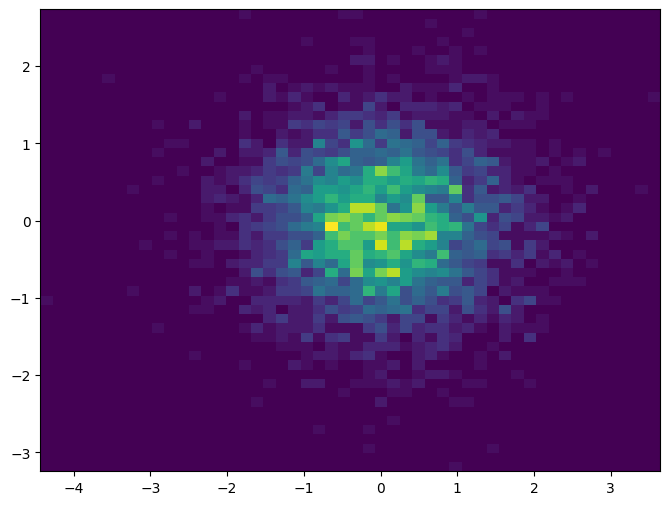

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=19.398725509643555, val_loss=66.83479347737631


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=16.814640045166016, val_loss=61.46299277750651


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=15.669312477111816, val_loss=63.439535858154294


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=15.840340614318848, val_loss=61.59833010864258


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=13.975447654724121, val_loss=65.03181771850586


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=14.938658714294434, val_loss=65.0952260538737


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=15.094127655029297, val_loss=63.54719506835937


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=13.976153373718262, val_loss=66.01217033894856


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=13.726322174072266, val_loss=62.634181701660154


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=14.988567352294922, val_loss=63.16500287882487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=14.053194999694824, val_loss=62.22291764322917


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=13.399383544921875, val_loss=67.41160880533855


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=13.367471694946289, val_loss=65.02299449666342


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=12.772053718566895, val_loss=64.04056034342447


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=13.999302864074707, val_loss=62.80763410441081


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=12.4540376663208, val_loss=64.42576614379882


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=13.224752426147461, val_loss=63.5684560546875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=13.03735637664795, val_loss=65.52166223144532


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=13.683504104614258, val_loss=63.54011175537109


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=12.093216896057129, val_loss=64.87333120727538


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=12.596137046813965, val_loss=64.09384829711914


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=12.826556205749512, val_loss=65.18996514892578


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=12.434063911437988, val_loss=64.84800792439779


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=12.546143531799316, val_loss=63.57300141398112


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=13.053034782409668, val_loss=63.94884333292643


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=10.80322551727295, val_loss=63.55389392089844


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=11.779420852661133, val_loss=64.83845739746094


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=12.088783264160156, val_loss=64.38471759033203


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=11.32281494140625, val_loss=64.48390283203125


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=11.39333438873291, val_loss=64.4961542561849


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=11.918876647949219, val_loss=63.73220167032878


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=12.1655855178833, val_loss=65.38899495442708


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=11.730634689331055, val_loss=64.7172534790039


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=11.73392391204834, val_loss=64.5754875793457


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=12.803145408630371, val_loss=64.5716230875651


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=11.172152519226074, val_loss=64.5071214090983


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=11.563458442687988, val_loss=64.65986185709636


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=11.55482292175293, val_loss=64.51700193277995


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=11.31092357635498, val_loss=64.02766254679362


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=11.474721908569336, val_loss=63.89631870524089


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=12.742713928222656, val_loss=64.51482400512695


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=11.165243148803711, val_loss=64.75847164916992


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=11.936091423034668, val_loss=64.62781398518881


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=11.247030258178711, val_loss=64.46474165852865


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=11.956469535827637, val_loss=64.31200491333007


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=11.39628791809082, val_loss=64.11429681396484


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=12.585921287536621, val_loss=64.92732760620117


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=11.106630325317383, val_loss=64.42687701416015


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=11.217878341674805, val_loss=64.31461681111654


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=10.797774314880371, val_loss=63.99979007975261


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=11.106802940368652, val_loss=64.63365804036458


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=11.017663955688477, val_loss=64.3340168355306


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=11.234078407287598, val_loss=64.44462776692708


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=10.974813461303711, val_loss=64.27795844523112


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=11.017967224121094, val_loss=64.27318125406902


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=10.706611633300781, val_loss=64.31184725952149


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=10.899531364440918, val_loss=65.56263488769531


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=11.505844116210938, val_loss=63.9843469136556


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=11.145617485046387, val_loss=64.27674987792969


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=10.59769058227539, val_loss=64.15194868977865


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=10.93761920928955, val_loss=64.51218873087565


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=11.142308235168457, val_loss=64.18781635538737


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 65.04151268513998


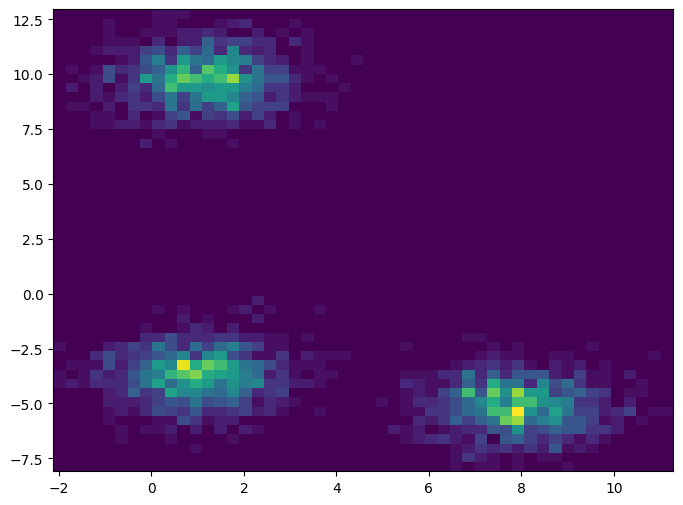

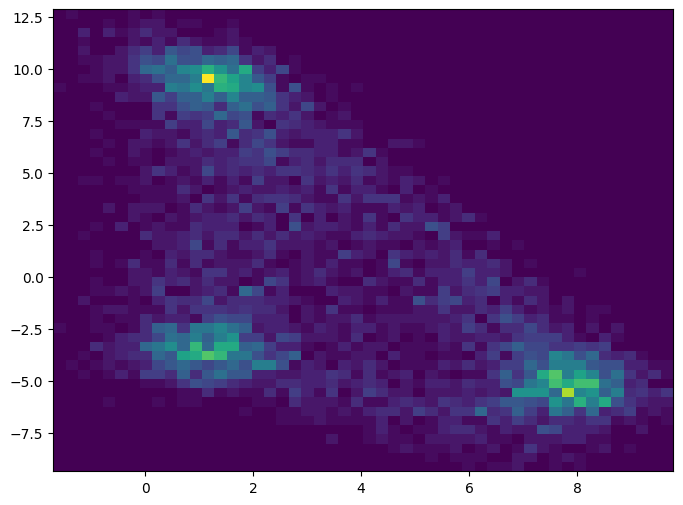

input_dim = 25
loss: 32.08153184000651


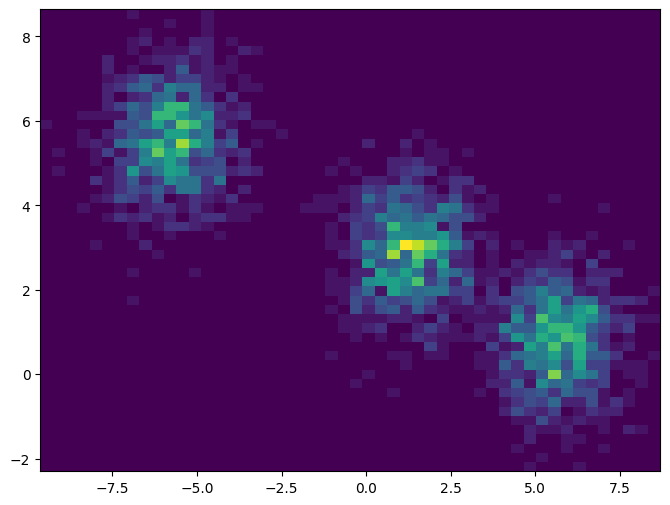

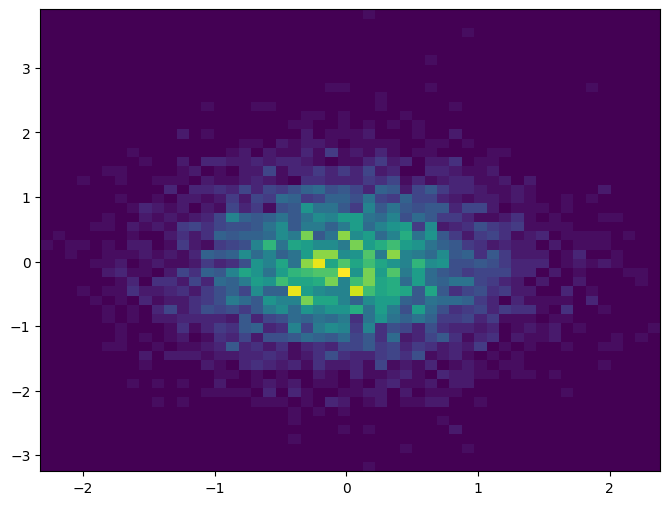

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=36.85956954956055, val_loss=43.138054738362634


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=32.291446685791016, val_loss=43.491531107584635


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=32.696434020996094, val_loss=43.4164372660319


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=32.86552810668945, val_loss=42.96325843302409


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=31.252140045166016, val_loss=43.27243435668945


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=30.441328048706055, val_loss=44.16054819742838


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=31.106412887573242, val_loss=42.583973999023435


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=29.884279251098633, val_loss=44.25242079671224


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=31.389474868774414, val_loss=44.06265776570638


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=29.971195220947266, val_loss=42.87839538574219


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.145709991455078, val_loss=42.35305459594726


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=29.608537673950195, val_loss=42.390712646484374


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=30.115028381347656, val_loss=42.72874399820964


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=28.001935958862305, val_loss=43.97784681193034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=29.496963500976562, val_loss=42.4772058207194


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=29.992822647094727, val_loss=43.659805409749346


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=29.659685134887695, val_loss=43.50611473592122


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=28.687057495117188, val_loss=42.95207009887695


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=28.242746353149414, val_loss=43.42982539876302


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=28.477861404418945, val_loss=42.91467702229818


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=29.028995513916016, val_loss=43.084202412923176


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=28.6231746673584, val_loss=43.44972566731771


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=29.496776580810547, val_loss=42.945456756591796


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=28.806194305419922, val_loss=42.55253889973958


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=28.88031005859375, val_loss=43.21784144083659


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=28.764019012451172, val_loss=43.1011125793457


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=26.44994354248047, val_loss=42.836129475911456


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=27.746965408325195, val_loss=42.9810988667806


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=27.45842933654785, val_loss=43.793262145996096


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=27.556713104248047, val_loss=43.528801116943356


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=27.813613891601562, val_loss=43.04534043375651


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=27.33768081665039, val_loss=43.386424336751304


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=28.630714416503906, val_loss=43.36083922322591


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=25.54054832458496, val_loss=43.54757561238607


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=26.83822250366211, val_loss=43.42452300008138


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=28.34881019592285, val_loss=43.72989092000326


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.81114959716797, val_loss=43.209747955322264


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=26.262462615966797, val_loss=43.07722089640299


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=26.751543045043945, val_loss=42.949173350016274


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=27.282663345336914, val_loss=42.86756147257487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=26.824119567871094, val_loss=43.273633443196616


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=26.962890625, val_loss=43.58871032714844


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=27.349994659423828, val_loss=43.465522481282555


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=25.584716796875, val_loss=43.16624785359701


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=26.156097412109375, val_loss=43.55525897216797


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=27.62906837463379, val_loss=43.059852345784506


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=31.171131134033203, val_loss=43.15514518229167


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=24.525020599365234, val_loss=43.27030954996745


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=26.697843551635742, val_loss=43.35834104410807


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=25.81942367553711, val_loss=43.427520253499345


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=25.221649169921875, val_loss=43.587777801513674


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=27.385595321655273, val_loss=43.00415450032552


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=25.478057861328125, val_loss=43.30294770304362


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=27.914608001708984, val_loss=43.22633274332682


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=26.296016693115234, val_loss=43.20116978963216


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=26.907760620117188, val_loss=42.91517230224609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=25.75356674194336, val_loss=43.19383352661133


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=26.00920295715332, val_loss=43.464672424316404


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=25.821773529052734, val_loss=43.33529553222656


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=26.208982467651367, val_loss=43.12907357788086


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=26.692176818847656, val_loss=43.12545061238607


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=24.90499496459961, val_loss=43.398042653401696


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 43.183254333496095


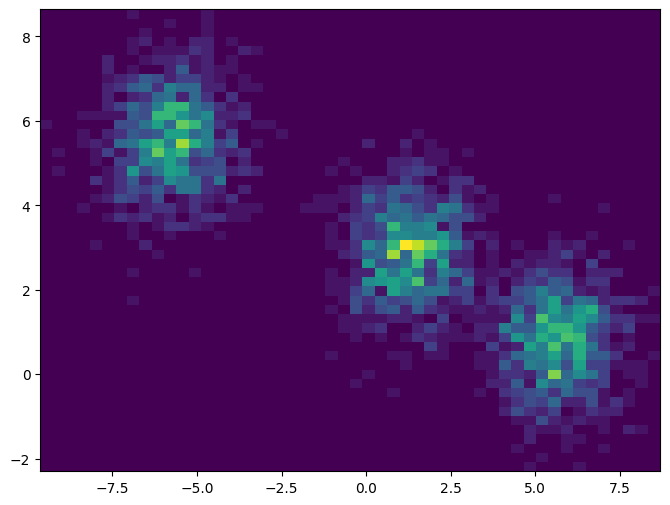

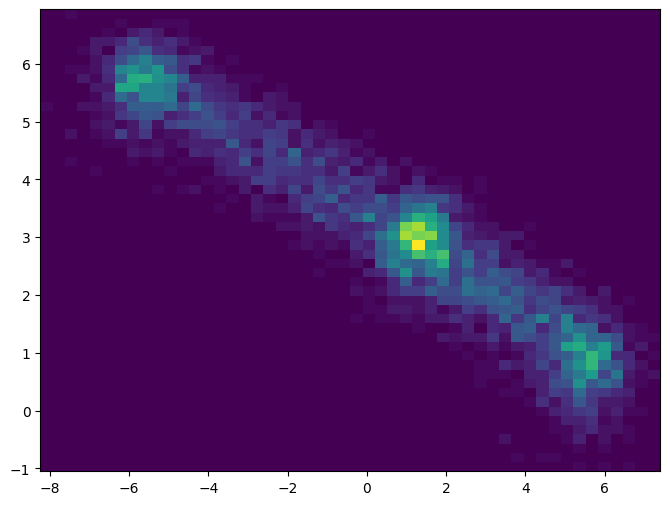

input_dim = 50
loss: 34.149200510660805


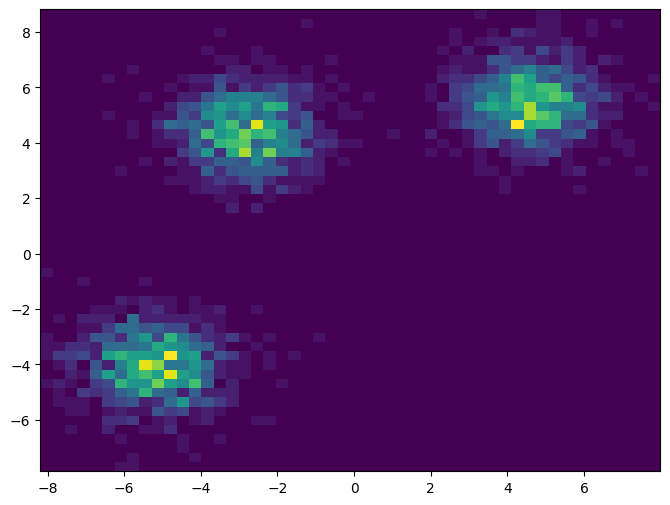

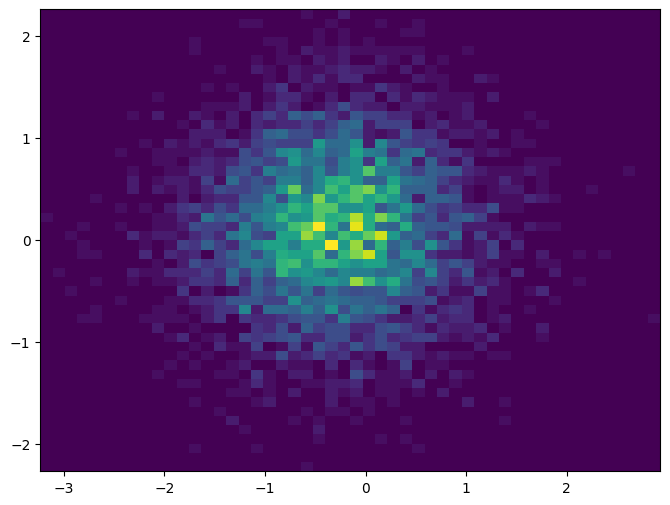

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=65.2459716796875, val_loss=42.94267196655274


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=63.98225402832031, val_loss=42.97810114542643


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=57.61076736450195, val_loss=43.54319498697917


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=59.56310272216797, val_loss=43.39750170898437


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=58.68495178222656, val_loss=42.81958751424153


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=58.396366119384766, val_loss=42.70974066162109


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=56.519195556640625, val_loss=42.645203236897785


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=56.870018005371094, val_loss=43.41011055501302


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=57.031917572021484, val_loss=42.983815928141276


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=56.5284423828125, val_loss=43.13164818318685


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=55.906925201416016, val_loss=42.60809773763021


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=56.526039123535156, val_loss=42.829444519042966


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=56.75690841674805, val_loss=42.594497467041016


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=55.47182846069336, val_loss=43.81676746622721


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=53.358524322509766, val_loss=42.81402630615234


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=55.766929626464844, val_loss=43.29543888346354


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=56.70937728881836, val_loss=43.10097260538737


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=56.7969856262207, val_loss=43.39032349650065


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=54.79353332519531, val_loss=43.46772419230143


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=56.148292541503906, val_loss=42.91993772379557


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=54.986270904541016, val_loss=43.251930826822914


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=56.21534729003906, val_loss=43.529951772054034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=55.973594665527344, val_loss=42.67868954467774


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=54.481937408447266, val_loss=42.75748216756185


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=54.351966857910156, val_loss=43.01838993326823


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=54.365875244140625, val_loss=43.14624666341146


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=52.64287567138672, val_loss=42.795423756917316


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=52.94184875488281, val_loss=43.140548970540365


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=55.84362030029297, val_loss=42.72563152058919


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=53.45216751098633, val_loss=43.148470733642576


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=51.63071060180664, val_loss=42.538307759602866


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=53.04426956176758, val_loss=42.88230404663086


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=53.45785903930664, val_loss=43.40686898803711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=53.38371658325195, val_loss=43.23085690307617


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=53.64118576049805, val_loss=42.32983317057292


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=54.094642639160156, val_loss=42.79326114908854


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=52.144264221191406, val_loss=42.624268361409506


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=53.237056732177734, val_loss=42.97776180013021


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=54.54554748535156, val_loss=42.810049977620444


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=54.6572265625, val_loss=42.72494775390625


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=55.496978759765625, val_loss=43.16536419677735


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=52.30604553222656, val_loss=42.76032305908203


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=52.235382080078125, val_loss=42.705750356038415


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=52.501033782958984, val_loss=42.73785008748372


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=54.487548828125, val_loss=43.072874867757164


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=52.82337951660156, val_loss=42.67063929239909


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=50.69264221191406, val_loss=42.8618176167806


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=52.15557098388672, val_loss=42.69058862304688


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=51.42670822143555, val_loss=43.49274252319336


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=52.235897064208984, val_loss=43.002767578125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=53.67647171020508, val_loss=42.917933685302735


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=51.386295318603516, val_loss=42.69428317260742


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=49.815406799316406, val_loss=42.72381962076823


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=51.46940994262695, val_loss=42.594194264729815


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=52.34547805786133, val_loss=42.65890563964844


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=51.14723205566406, val_loss=42.56879053751628


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=53.87287521362305, val_loss=43.29496908569336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=53.77244567871094, val_loss=42.94035084025065


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=51.24298095703125, val_loss=42.97390504964193


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=51.00924301147461, val_loss=43.07532522583008


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=51.76170349121094, val_loss=42.82230120849609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=51.599693298339844, val_loss=42.74483005777995


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 42.92568740844727


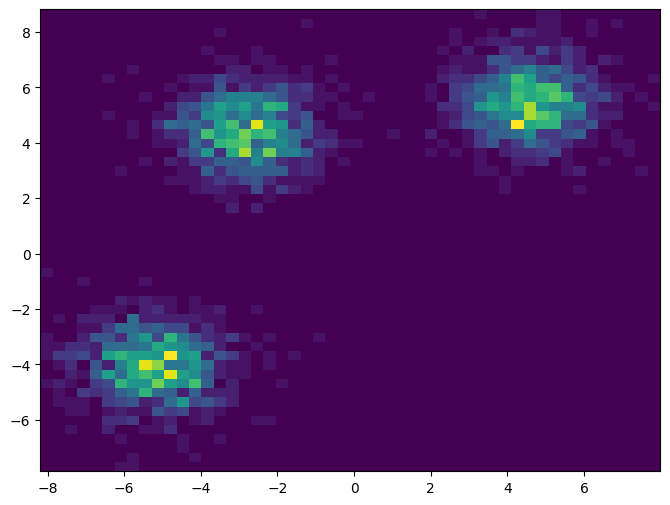

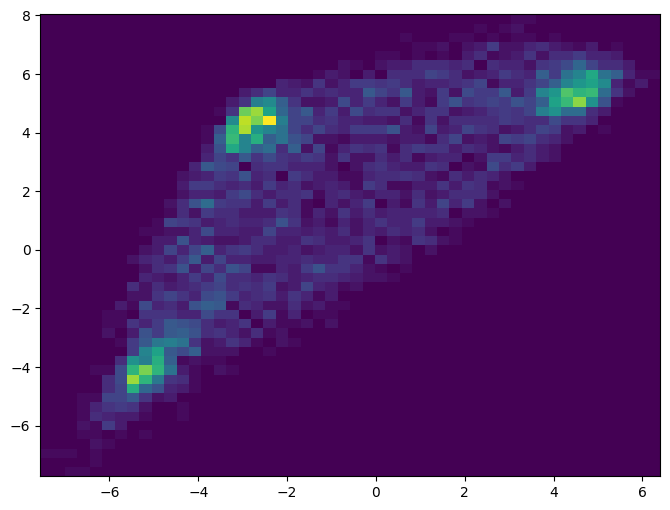

In [16]:
for input_dim in input_dim_params:
    print(f'input_dim = {input_dim}')
    train_dataset, test_dataset = gauss_clusters(number_clusters=3, number_samples=5000, vector_size=input_dim)
    model = VAE(latent_dim=10, input_dim=input_dim, hidden_dim=1000)
    model.to(device)
    writer = SummaryWriter(log_dir = f'tensorboard4/input_dim_{input_dim}')
    call = callback(writer, test_dataset, loss_function)
    check_model(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100, 
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check_model(64, test_dataset, model, loss_function)

relationship = 0.5
loss: 44.96088801066081


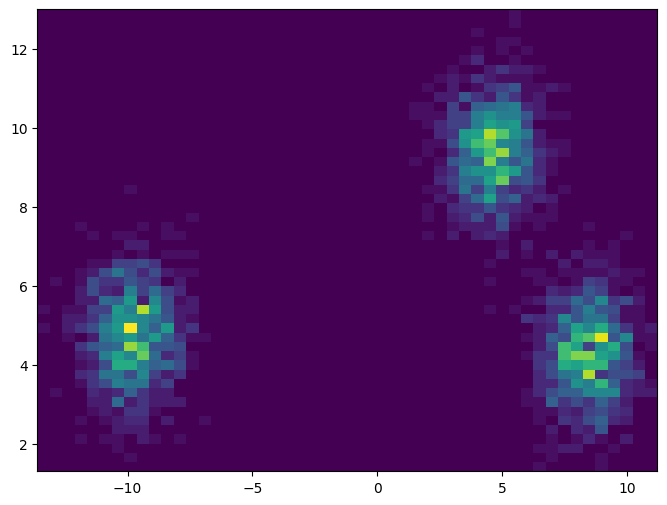

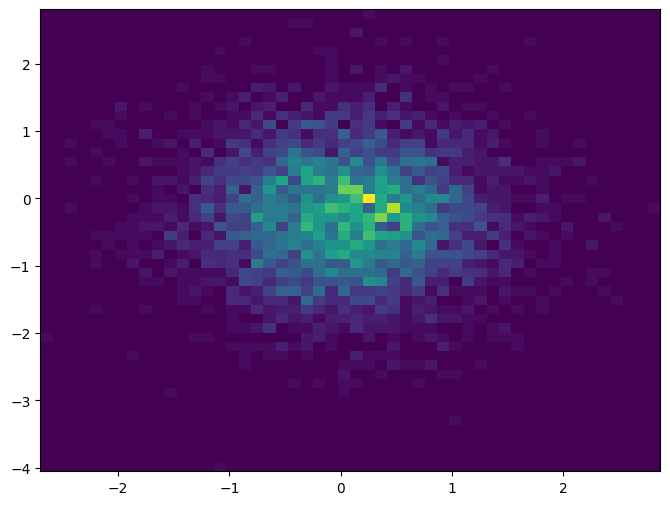

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=40.08552551269531, val_loss=42.2606413675944


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=35.9466552734375, val_loss=43.027975657145184


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=33.981285095214844, val_loss=43.40179525756836


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=33.278263092041016, val_loss=42.48451392618815


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=30.762775421142578, val_loss=43.50132061767578


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=30.078670501708984, val_loss=42.83167987060547


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=28.548568725585938, val_loss=43.23038567097982


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=30.487060546875, val_loss=43.088062917073565


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=30.43134117126465, val_loss=42.48318379720052


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=29.926834106445312, val_loss=42.91378780110677


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=28.35602378845215, val_loss=43.08610294596354


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=27.339967727661133, val_loss=43.533149892171224


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=28.473838806152344, val_loss=42.397674936930336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=29.948705673217773, val_loss=43.13255580647787


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=27.32819366455078, val_loss=43.83462754313151


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=27.842981338500977, val_loss=42.54579184977214


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=27.309816360473633, val_loss=42.83434394327799


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=28.673635482788086, val_loss=42.31156490071614


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=27.63323402404785, val_loss=42.76420356241862


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=28.030038833618164, val_loss=43.302728088378906


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=28.690486907958984, val_loss=43.36979011027018


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=27.53011131286621, val_loss=42.457231669108076


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=28.29323959350586, val_loss=43.19375500488281


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=27.215354919433594, val_loss=42.56885370890299


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=27.284502029418945, val_loss=42.91826210530599


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=27.30261993408203, val_loss=43.057237497965495


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=27.873706817626953, val_loss=43.00709721883138


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=27.293315887451172, val_loss=43.326924397786456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=28.11601448059082, val_loss=42.980473012288414


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=27.881912231445312, val_loss=42.45331435139974


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=28.101198196411133, val_loss=42.57384135945638


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=27.051837921142578, val_loss=42.503607228597005


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=27.844785690307617, val_loss=43.51385832722982


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=26.475088119506836, val_loss=42.761613759358724


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=27.840299606323242, val_loss=43.1361549987793


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=27.038843154907227, val_loss=43.41815571085612


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=26.1742000579834, val_loss=42.79508305867513


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=27.063072204589844, val_loss=43.181472890218096


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=27.024423599243164, val_loss=42.92071805826823


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=26.798168182373047, val_loss=43.246390614827476


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=27.01997184753418, val_loss=43.03196266682943


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=25.572439193725586, val_loss=42.994845245361326


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=25.792236328125, val_loss=42.334861745198566


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=27.380788803100586, val_loss=43.02452854410807


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=27.40573501586914, val_loss=43.14644513956706


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=27.971988677978516, val_loss=43.06620977783203


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=27.267871856689453, val_loss=42.67400743611654


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=25.354896545410156, val_loss=43.50519821166992


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=25.4124698638916, val_loss=42.90708573404948


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=25.27971076965332, val_loss=42.95223393758138


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=26.515823364257812, val_loss=42.79892469278971


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=26.318742752075195, val_loss=42.99526722208659


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=24.244956970214844, val_loss=43.22952879842122


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=26.73757553100586, val_loss=42.924182189941405


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=26.283185958862305, val_loss=42.99117396036784


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=26.30609893798828, val_loss=42.82262798055013


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=25.794513702392578, val_loss=42.79323620605469


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=27.190645217895508, val_loss=42.92776351928711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=25.569534301757812, val_loss=43.1392990620931


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=24.948688507080078, val_loss=42.627755259195965


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=25.39823341369629, val_loss=43.018978810628255


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=27.18000602722168, val_loss=42.92561381022136


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 43.011202799479165


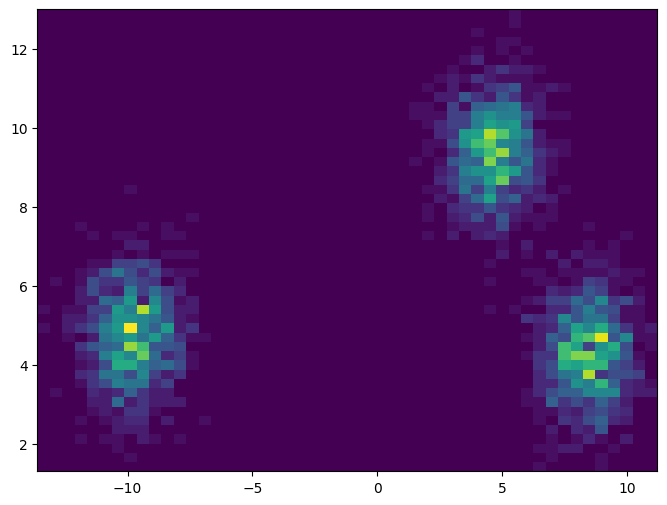

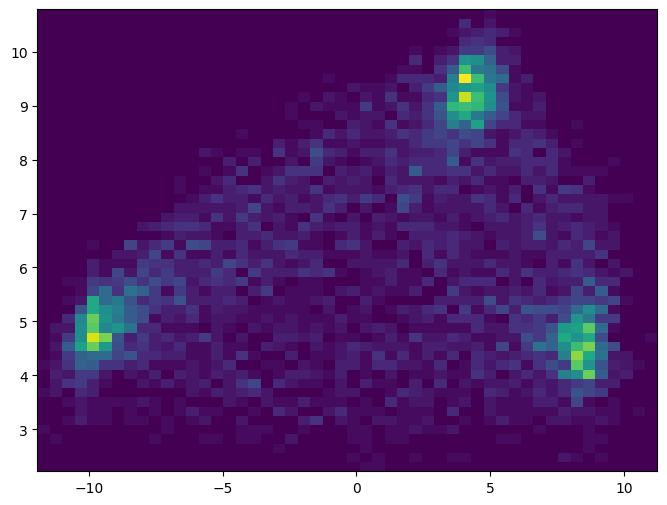

relationship = 1
loss: 45.56335517374674


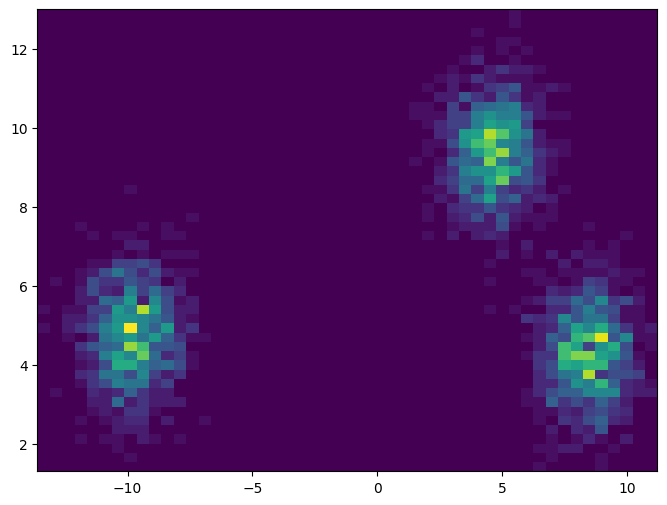

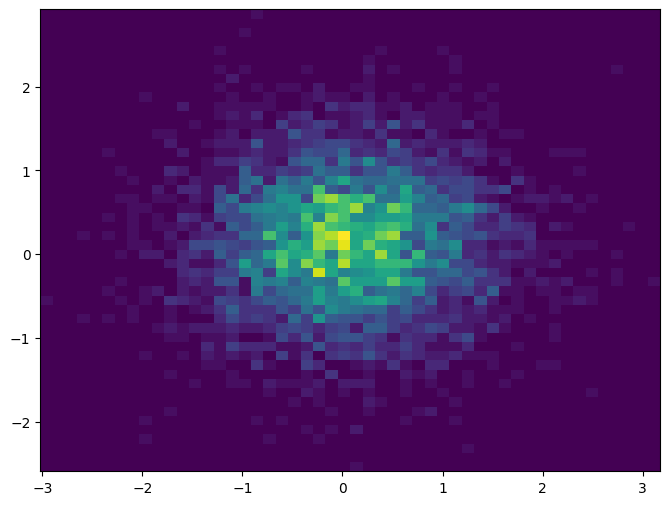

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=46.88656997680664, val_loss=43.61709343465169


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=37.98316955566406, val_loss=43.595901529947916


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=33.612632751464844, val_loss=43.32511293538411


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=32.00685119628906, val_loss=43.145901631673176


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=32.54481506347656, val_loss=43.0607278137207


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=29.884828567504883, val_loss=43.711679860432945


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=30.626018524169922, val_loss=43.77202577718099


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=28.704866409301758, val_loss=43.27090464274089


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=28.34499740600586, val_loss=43.08639860026042


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=28.61017417907715, val_loss=42.865287363688154


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=28.133621215820312, val_loss=42.83950710042318


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=27.93603515625, val_loss=43.32993606567383


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=25.7124080657959, val_loss=43.316771606445315


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=27.715835571289062, val_loss=43.02259531656901


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=27.25432777404785, val_loss=43.201810770670576


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=27.026641845703125, val_loss=43.46273125203451


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=27.533008575439453, val_loss=43.504311798095706


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=25.855356216430664, val_loss=43.19477569580078


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=26.392709732055664, val_loss=43.29771890258789


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=25.887149810791016, val_loss=43.369800364176434


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=25.117443084716797, val_loss=42.831959696451825


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=25.635465621948242, val_loss=43.25167498779297


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=26.071460723876953, val_loss=42.982941111246745


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=26.51407814025879, val_loss=42.96152967325846


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=26.090913772583008, val_loss=42.87343163045247


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=24.959938049316406, val_loss=43.10980956013997


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=25.432870864868164, val_loss=42.698635009765624


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=25.738210678100586, val_loss=43.44858842976888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=25.54547882080078, val_loss=42.82865129597982


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=26.2047061920166, val_loss=43.110021555582684


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=26.54153060913086, val_loss=42.73254342651367


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=26.113744735717773, val_loss=43.30339603678385


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=26.94464874267578, val_loss=42.85933723958333


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=26.40566062927246, val_loss=43.25642138671875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=26.434303283691406, val_loss=43.062647918701174


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=25.845186233520508, val_loss=43.44780694580078


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=26.570758819580078, val_loss=43.07655135091146


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=25.318546295166016, val_loss=43.47854934692383


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=24.945919036865234, val_loss=43.15512456258138


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=26.018217086791992, val_loss=42.87500639851888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=26.598295211791992, val_loss=43.19183255004883


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=25.303632736206055, val_loss=43.882659474690755


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=25.578950881958008, val_loss=43.37502627563477


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=25.35838508605957, val_loss=43.25796156819661


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=25.667034149169922, val_loss=43.05826529947917


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=25.783283233642578, val_loss=43.004662628173826


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=27.95612144470215, val_loss=43.99371439615886


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=26.264358520507812, val_loss=43.14186070760091


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=25.53548812866211, val_loss=43.167964935302734


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=24.610687255859375, val_loss=43.172167083740234


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=23.803115844726562, val_loss=43.046845998128255


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=24.33392906188965, val_loss=43.4114328511556


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=26.248130798339844, val_loss=43.093906188964844


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=25.840051651000977, val_loss=43.193479268391926


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=25.79860496520996, val_loss=42.88817463175456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=24.205345153808594, val_loss=43.012326283772786


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=25.548974990844727, val_loss=43.55625336710612


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=25.197248458862305, val_loss=42.98807167561849


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=24.868370056152344, val_loss=43.03384900919596


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=24.16867446899414, val_loss=42.70836216227214


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=25.12615203857422, val_loss=43.23435853068034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=25.368331909179688, val_loss=43.2690222269694


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 43.71189993286133


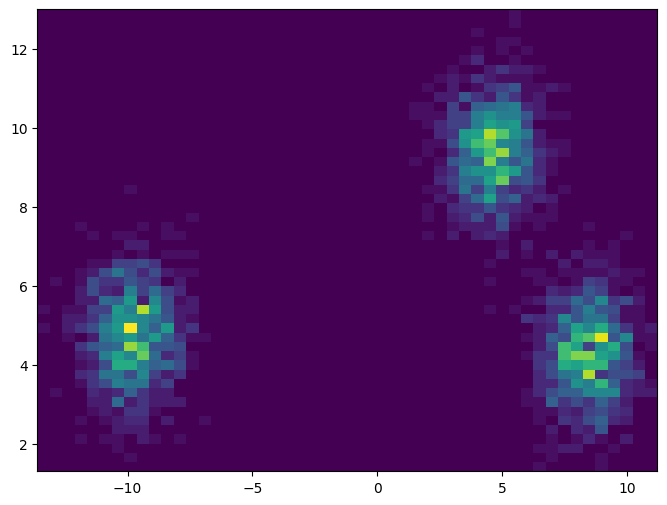

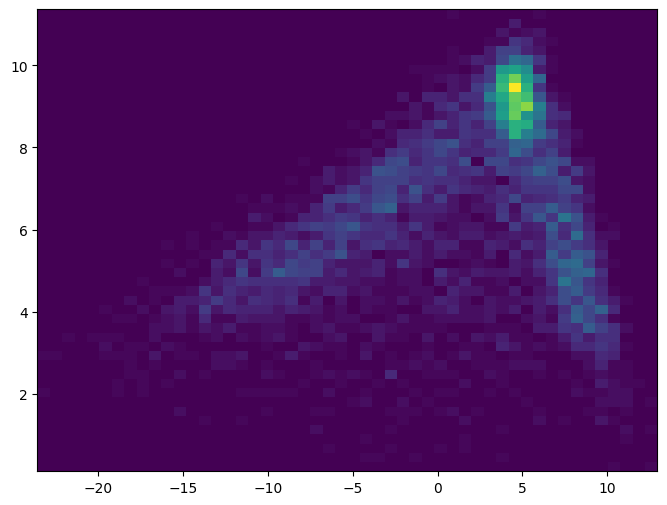

relationship = 2
loss: 46.30734357706706


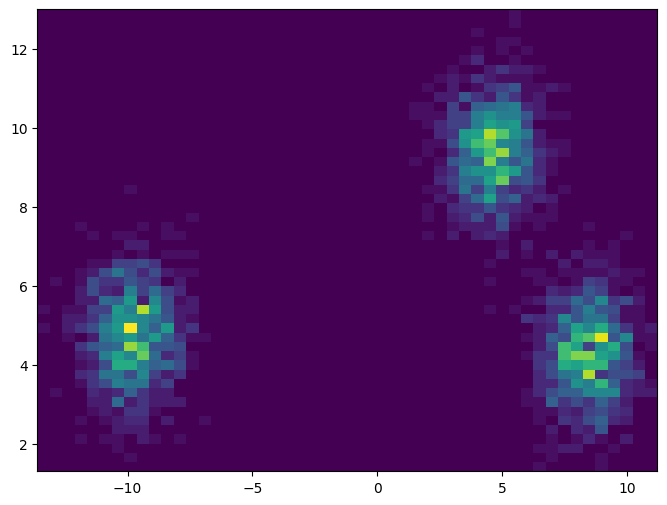

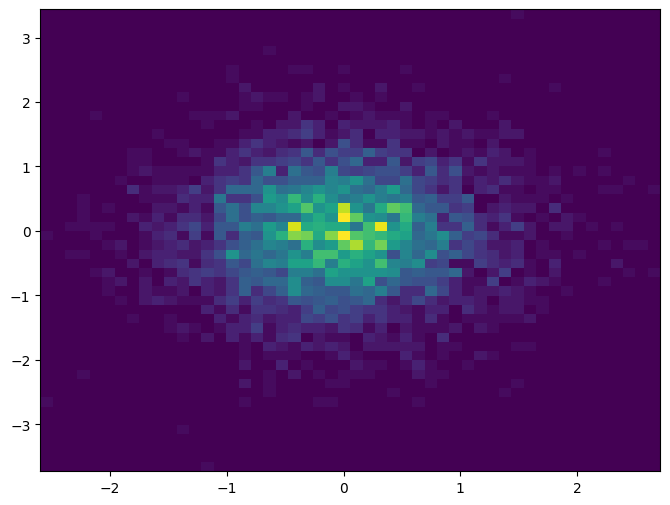

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=54.77752685546875, val_loss=42.475453043619794


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=41.625308990478516, val_loss=42.11460231526693


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=38.250919342041016, val_loss=41.95997010294597


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=33.386924743652344, val_loss=42.743592783610026


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=32.67629623413086, val_loss=43.77585563151042


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=31.153270721435547, val_loss=42.21638517252604


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=30.197357177734375, val_loss=43.379444295247396


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=29.75276756286621, val_loss=42.933870819091794


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=29.449064254760742, val_loss=43.238275024414065


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=28.066354751586914, val_loss=42.92120492553711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=28.222808837890625, val_loss=43.8101914469401


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=25.874956130981445, val_loss=43.89370919799805


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=28.41216278076172, val_loss=43.50742244466146


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=27.442968368530273, val_loss=42.967071024576825


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=26.411100387573242, val_loss=43.689739400227865


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=28.758636474609375, val_loss=43.21093701171875


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=27.526763916015625, val_loss=43.41709594726562


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=28.187583923339844, val_loss=43.146208140055336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=26.950345993041992, val_loss=43.13445337931315


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=28.826251983642578, val_loss=42.91322448730469


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=25.785751342773438, val_loss=43.32284674072265


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=27.444852828979492, val_loss=42.65374685668945


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=27.433979034423828, val_loss=42.774562306722004


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=27.501708984375, val_loss=43.96245086669922


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=26.879688262939453, val_loss=43.448017018636065


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=26.670852661132812, val_loss=43.88144763183594


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=27.930328369140625, val_loss=42.500767669677735


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=27.5941104888916, val_loss=43.04443903605143


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=25.073131561279297, val_loss=43.19392133585612


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=25.716548919677734, val_loss=43.36342471313476


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=26.441505432128906, val_loss=43.65070088704427


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=26.06096839904785, val_loss=43.98612736002604


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=26.354595184326172, val_loss=42.90194742838542


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=26.811403274536133, val_loss=43.21551375325521


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=25.796884536743164, val_loss=42.536146789550784


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=26.26647186279297, val_loss=43.380071065266925


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.625768661499023, val_loss=42.3898120320638


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=26.166902542114258, val_loss=43.0190249226888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=25.96246910095215, val_loss=42.937723907470705


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=25.227724075317383, val_loss=42.73750504557292


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=25.879411697387695, val_loss=42.72726531982422


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=27.720111846923828, val_loss=43.31182222493489


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=26.79986572265625, val_loss=42.7934333597819


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=26.63224983215332, val_loss=42.98778512573242


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=26.088096618652344, val_loss=43.111700439453124


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=26.5246639251709, val_loss=43.12790577189128


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=26.070371627807617, val_loss=43.771169901529944


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=26.401657104492188, val_loss=42.76640553792318


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=25.787538528442383, val_loss=43.60331676228841


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=25.314638137817383, val_loss=42.778089141845705


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=25.994945526123047, val_loss=42.81645815022787


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=25.744787216186523, val_loss=43.07093037923177


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=26.705129623413086, val_loss=42.56453662109375


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=25.692020416259766, val_loss=43.52277685546875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=25.70062828063965, val_loss=43.12075652058919


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=25.800451278686523, val_loss=43.204741485595704


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=26.233928680419922, val_loss=42.99225173950195


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=26.10304069519043, val_loss=43.01572132364909


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=25.111202239990234, val_loss=43.04997295125325


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=26.40631103515625, val_loss=43.20830731201172


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=25.38151741027832, val_loss=43.05001542154948


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=25.039762496948242, val_loss=42.979677846272786


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 43.334340759277346


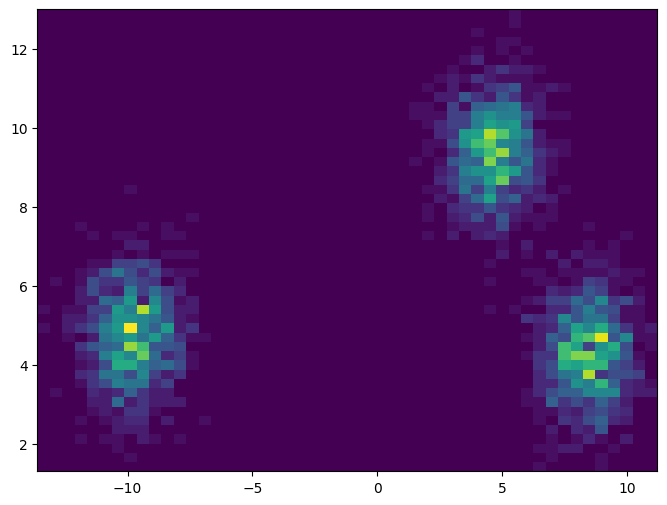

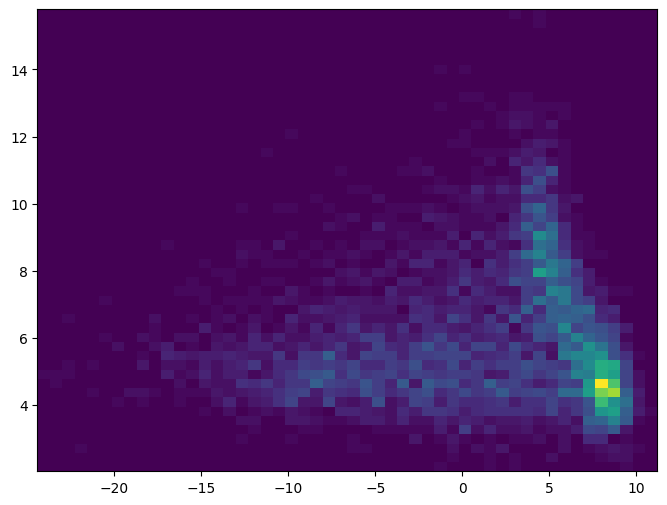

In [17]:
vector_size = 25
train_dataset, test_dataset = gauss_clusters(number_clusters=3, number_samples=5000, vector_size=vector_size)
for relationship in relationship_params:
    print(f'relationship = {relationship}')
    model = VAE(latent_dim=int(relationship * vector_size), input_dim=vector_size, hidden_dim=1000)
    model.to(device)
    writer = SummaryWriter(log_dir = f'tensorboard4/relationship_{relationship}')
    call = callback(writer, test_dataset, loss_function)
    check_model(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100, 
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check_model(64, test_dataset, model, loss_function)

hidden_dim = 250
loss: 39.06830743408203


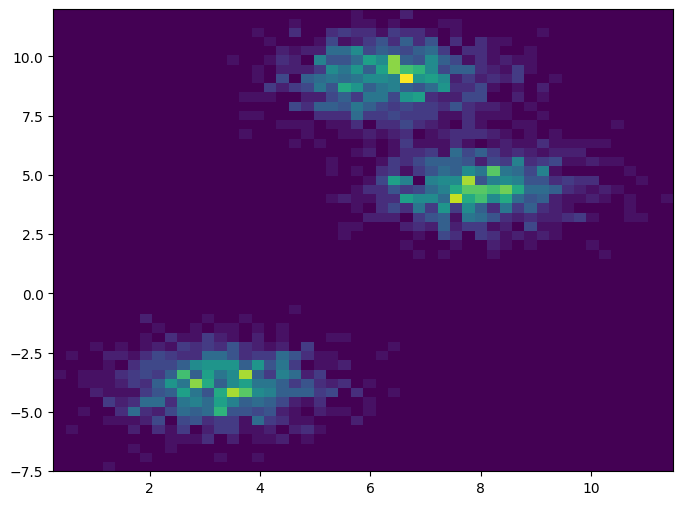

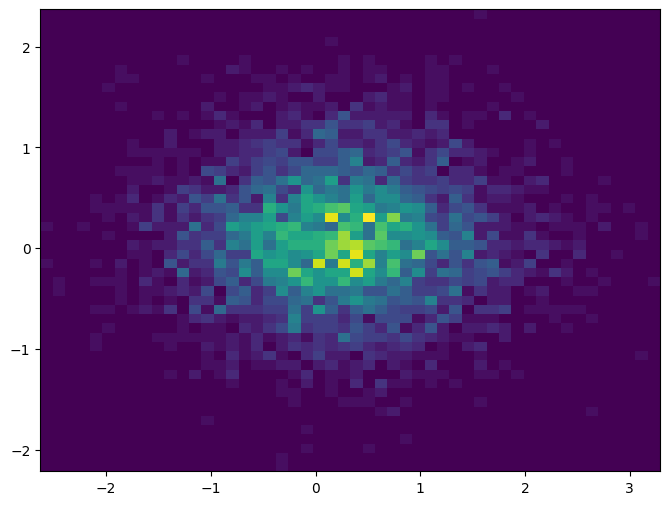

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=44.553985595703125, val_loss=58.25115071614584


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=37.341007232666016, val_loss=58.72760373942057


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=37.337608337402344, val_loss=57.56864909871419


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=33.28062438964844, val_loss=59.366585642496744


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=32.789215087890625, val_loss=59.30269436645508


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=30.603078842163086, val_loss=59.40000795491537


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=31.44435691833496, val_loss=59.345248514811196


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=31.135889053344727, val_loss=58.779341033935545


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=31.005294799804688, val_loss=59.376324513753254


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=30.740253448486328, val_loss=58.881598459879555


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.074630737304688, val_loss=59.50202451578776


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=31.76420021057129, val_loss=58.863847890218096


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=31.169086456298828, val_loss=58.91131888834635


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=30.058528900146484, val_loss=59.54649176025391


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=29.13408660888672, val_loss=58.72054384358724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=28.921836853027344, val_loss=59.452543782552084


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=29.945392608642578, val_loss=59.90600658162435


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=30.314651489257812, val_loss=59.726444010416664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=30.14910888671875, val_loss=59.08006918334961


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=28.96702766418457, val_loss=59.52262510172526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=28.27591323852539, val_loss=59.1354621480306


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=27.314714431762695, val_loss=58.6469909769694


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=30.28608512878418, val_loss=58.468199513753255


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=29.183317184448242, val_loss=59.55948712158203


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=28.609161376953125, val_loss=59.06466620890299


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=29.426448822021484, val_loss=59.75710346476237


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=27.489059448242188, val_loss=58.68553644816081


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=28.95807456970215, val_loss=59.32202936808268


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=28.65589714050293, val_loss=58.92685021972656


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=27.323671340942383, val_loss=58.913815734863284


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=28.360658645629883, val_loss=59.22398944091797


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=28.026025772094727, val_loss=59.06927977498373


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=27.029464721679688, val_loss=59.45689604695638


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=29.94438362121582, val_loss=59.53747401936849


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=27.305484771728516, val_loss=58.95291987101237


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=26.881450653076172, val_loss=59.26708856201172


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.144025802612305, val_loss=58.69666923014323


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=28.386659622192383, val_loss=58.649582194010414


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=28.90188980102539, val_loss=59.14010589599609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=27.868593215942383, val_loss=58.203682495117185


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=28.450769424438477, val_loss=58.68972156778971


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=29.17135238647461, val_loss=59.41141264851888


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=27.814586639404297, val_loss=58.61578968302409


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=29.03809356689453, val_loss=59.794070638020834


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=27.82155418395996, val_loss=58.893033986409506


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=27.9730167388916, val_loss=59.07490201822917


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=28.16476058959961, val_loss=58.87663445027669


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=28.55723762512207, val_loss=59.87171647135417


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=28.97754669189453, val_loss=59.315632649739584


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=27.350189208984375, val_loss=59.318312642415364


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=26.350730895996094, val_loss=59.012690032958986


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=29.08739471435547, val_loss=59.33731036376953


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=27.966184616088867, val_loss=59.002964803059896


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=27.970251083374023, val_loss=58.73736509195964


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=27.86556053161621, val_loss=59.22961098225912


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=27.33551025390625, val_loss=59.160371063232425


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=27.646728515625, val_loss=58.83131802368164


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=27.468050003051758, val_loss=59.277313181559244


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=27.493318557739258, val_loss=58.83966069539388


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=27.158309936523438, val_loss=59.21549153645833


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=28.245716094970703, val_loss=58.82000159708659


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=27.903526306152344, val_loss=59.57303693644206


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 59.52961480712891


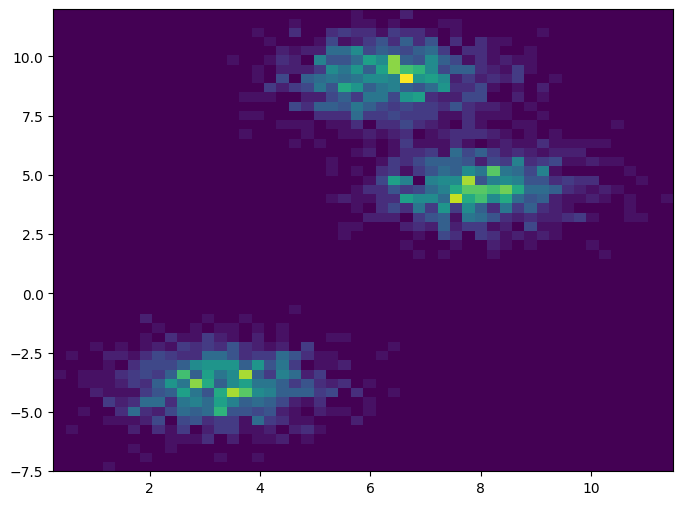

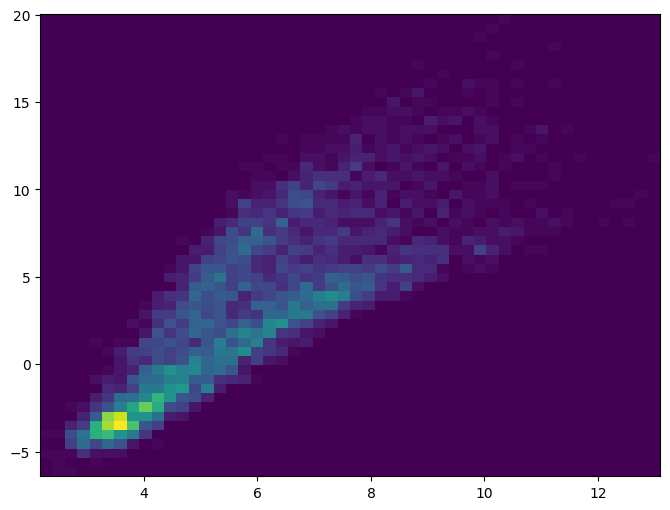

hidden_dim = 500
loss: 39.12849634806315


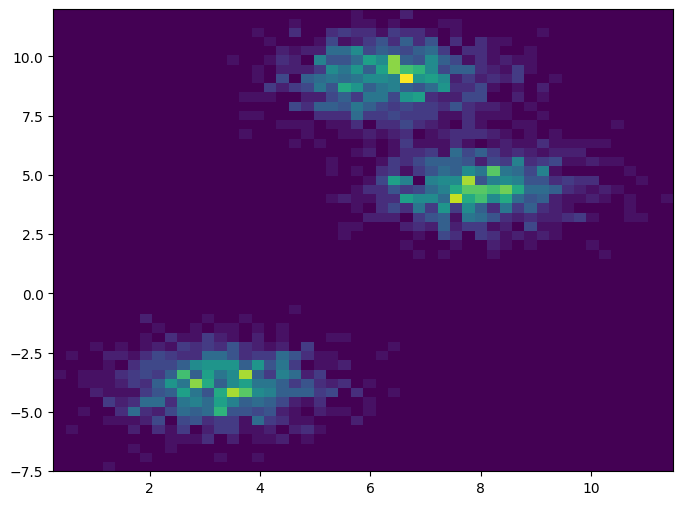

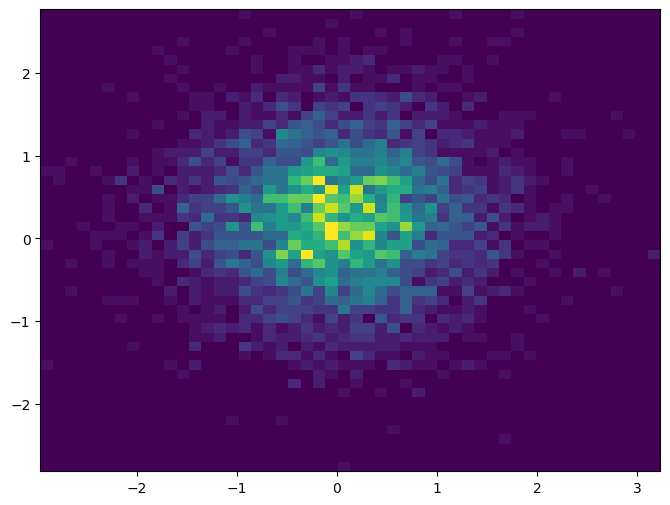

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=45.54206848144531, val_loss=59.251357259114585


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=39.09751892089844, val_loss=57.43106766764323


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=36.914093017578125, val_loss=56.10050039672851


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=34.520545959472656, val_loss=59.42192603556315


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=31.371078491210938, val_loss=59.0235405476888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=32.890403747558594, val_loss=59.29037088012695


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=32.389801025390625, val_loss=58.49494701131185


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=31.380592346191406, val_loss=58.9327400004069


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=30.50127410888672, val_loss=60.675715952555336


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=32.0328369140625, val_loss=58.551485107421875


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.415260314941406, val_loss=59.28661814371745


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=28.62132453918457, val_loss=58.86548332722982


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=30.40361785888672, val_loss=59.666742655436195


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=27.01264190673828, val_loss=59.94849296061198


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=28.052032470703125, val_loss=58.69354563395182


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=29.86655616760254, val_loss=59.42870658365885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=29.18851089477539, val_loss=59.86430434163412


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=29.3867244720459, val_loss=58.82957861328125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=30.019315719604492, val_loss=59.35227093505859


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=28.698230743408203, val_loss=58.939780110677084


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=29.118732452392578, val_loss=58.02172357177734


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=28.040254592895508, val_loss=59.620211313883466


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=29.254100799560547, val_loss=58.52132114664713


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=28.050142288208008, val_loss=58.92594633992513


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=28.23763084411621, val_loss=59.18898264567057


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=29.346240997314453, val_loss=59.306986053466794


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=28.718503952026367, val_loss=59.129971211751304


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=28.800016403198242, val_loss=59.19732039388021


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=28.275104522705078, val_loss=59.106384368896485


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=28.889129638671875, val_loss=58.78785069783529


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=28.10045623779297, val_loss=59.232834075927734


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=28.0283260345459, val_loss=59.06297633870442


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=26.219863891601562, val_loss=58.981743581136065


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=27.345563888549805, val_loss=59.27573241170247


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=28.477500915527344, val_loss=59.15470206705729


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=27.66831398010254, val_loss=59.51588851928711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=28.56712532043457, val_loss=59.57857766723633


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=27.161575317382812, val_loss=58.719864501953126


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=29.869937896728516, val_loss=59.473136657714846


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=26.690223693847656, val_loss=59.679443267822265


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=27.494529724121094, val_loss=59.436684224446616


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=26.39580535888672, val_loss=59.37589067586263


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=27.363880157470703, val_loss=59.7588761698405


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=27.018293380737305, val_loss=59.0035527750651


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=28.94358253479004, val_loss=58.95612606811523


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=28.28598976135254, val_loss=59.25928914388021


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=28.102279663085938, val_loss=58.39220393880208


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=28.137662887573242, val_loss=58.97298915608724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=28.755619049072266, val_loss=59.14292621866862


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=26.61237144470215, val_loss=59.16870816040039


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=27.726511001586914, val_loss=59.00857408650716


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=27.34809112548828, val_loss=59.432818623860676


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=27.2945499420166, val_loss=59.22243598429362


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=27.011320114135742, val_loss=58.80341849772135


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=26.346853256225586, val_loss=59.57229950968424


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=26.645503997802734, val_loss=58.62098236083985


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=27.666196823120117, val_loss=59.1757485148112


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=27.92287254333496, val_loss=59.143762247721355


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=27.326282501220703, val_loss=58.995055114746094


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=28.175251007080078, val_loss=59.43129534912109


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=28.462018966674805, val_loss=59.48634578450521


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=28.497007369995117, val_loss=59.30918143717448


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 58.67165118408203


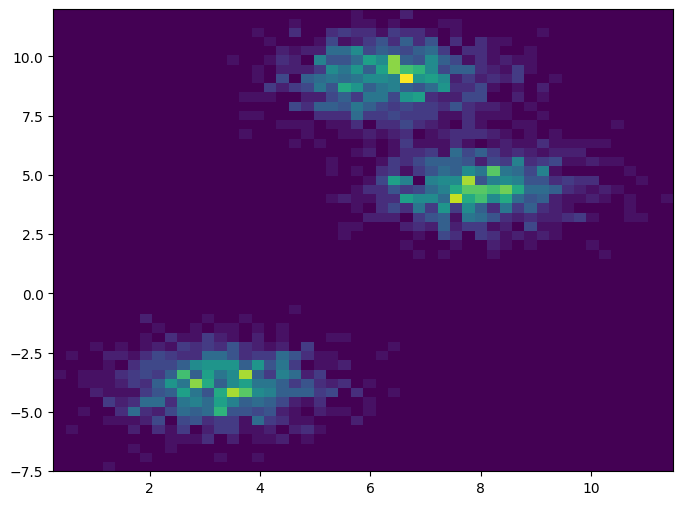

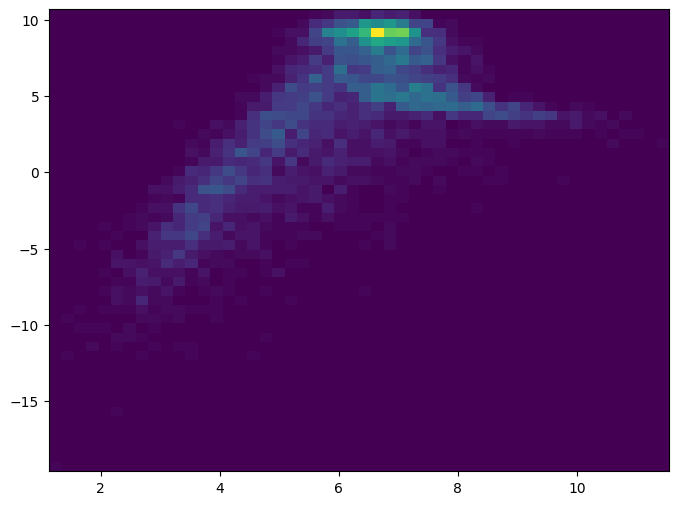

hidden_dim = 1000
loss: 39.62306278483073


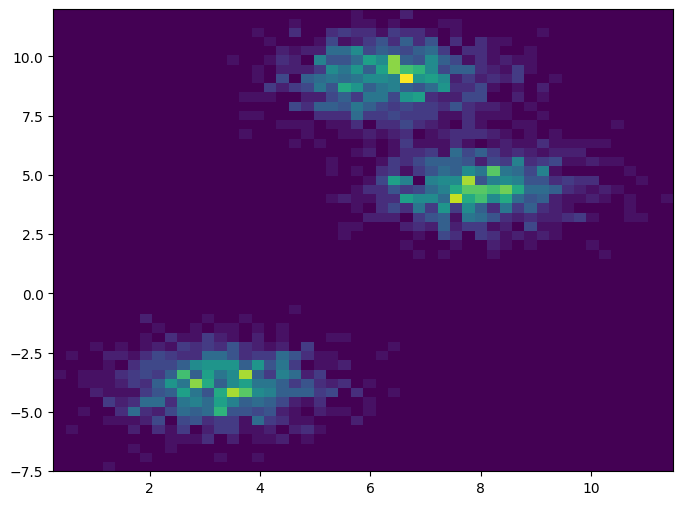

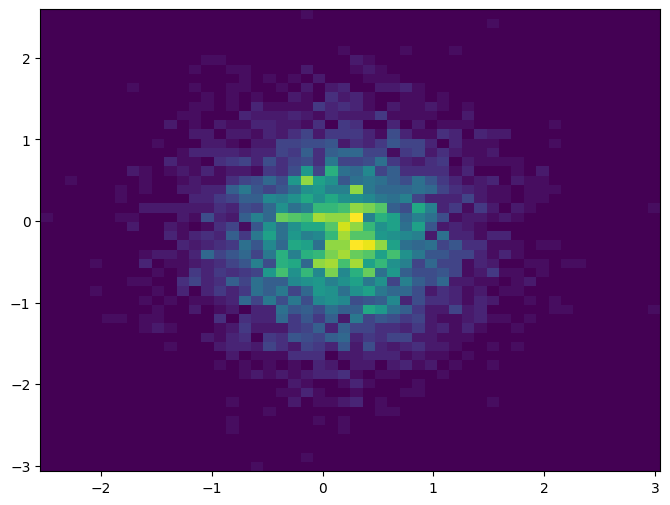

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=39.00150680541992, val_loss=58.75548420206706


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=35.49543380737305, val_loss=59.49184414672852


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=34.685081481933594, val_loss=59.358537953694665


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=32.634613037109375, val_loss=56.25476780192057


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=32.43515396118164, val_loss=59.666009602864584


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=31.865005493164062, val_loss=59.09715267944336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=31.031021118164062, val_loss=60.47730776977539


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=31.721670150756836, val_loss=59.154317728678386


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=29.89141082763672, val_loss=58.70407930501302


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=30.278276443481445, val_loss=59.247124430338545


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=29.495506286621094, val_loss=59.76555353800456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=31.22524642944336, val_loss=58.754943135579424


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=30.909696578979492, val_loss=59.98897205607096


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=30.163414001464844, val_loss=59.03212032063802


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=30.490331649780273, val_loss=59.55859395345052


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=29.551965713500977, val_loss=59.3569741007487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=30.748796463012695, val_loss=59.484995849609376


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=30.323360443115234, val_loss=59.26172353108724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=29.048696517944336, val_loss=59.1231850382487


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=29.448959350585938, val_loss=59.839353403727216


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=29.14111328125, val_loss=59.87164448038737


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=30.19661521911621, val_loss=59.255921875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=29.438077926635742, val_loss=60.1146162516276


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=29.34121322631836, val_loss=59.64174438476562


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=27.953903198242188, val_loss=59.27638762410482


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=29.561832427978516, val_loss=59.540642873128256


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=27.868202209472656, val_loss=58.974986348470054


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=28.509334564208984, val_loss=58.874445912679036


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=30.359325408935547, val_loss=58.90253428141276


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=29.005538940429688, val_loss=59.132535695393884


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=28.228538513183594, val_loss=59.254427459716794


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=28.556602478027344, val_loss=59.01102452596029


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=26.26988410949707, val_loss=59.2513234761556


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=28.823640823364258, val_loss=59.28007059733073


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=28.357831954956055, val_loss=58.62173690795898


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=29.274089813232422, val_loss=59.187717976888024


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=27.158002853393555, val_loss=59.52404848225911


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=28.518423080444336, val_loss=58.49640970865885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=27.189075469970703, val_loss=59.12367551676432


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=27.843252182006836, val_loss=58.96190734863281


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=26.634288787841797, val_loss=59.38357265218099


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=27.67605209350586, val_loss=58.88000950113932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=26.440715789794922, val_loss=58.982084167480465


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=28.461429595947266, val_loss=58.90037931315104


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=27.121305465698242, val_loss=59.37717365519206


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=26.934120178222656, val_loss=59.205207427978515


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=26.39950942993164, val_loss=59.39735077921549


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=27.447784423828125, val_loss=59.014390635172525


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=26.42756462097168, val_loss=59.37007074991862


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=27.180166244506836, val_loss=59.18217774454752


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=26.965538024902344, val_loss=59.498984568278


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=27.086990356445312, val_loss=58.95894530232747


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=28.130590438842773, val_loss=58.91316204833984


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=27.371131896972656, val_loss=59.34971275838216


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=26.445281982421875, val_loss=59.13376852416992


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=27.866830825805664, val_loss=59.177530029296875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=27.3208065032959, val_loss=59.346202158610026


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=27.201519012451172, val_loss=58.98369623819987


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=27.159549713134766, val_loss=59.33559508260091


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=26.659595489501953, val_loss=59.071417287190755


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=27.01638412475586, val_loss=58.9463889058431


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=26.473052978515625, val_loss=58.96535307820638


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 58.933543467203776


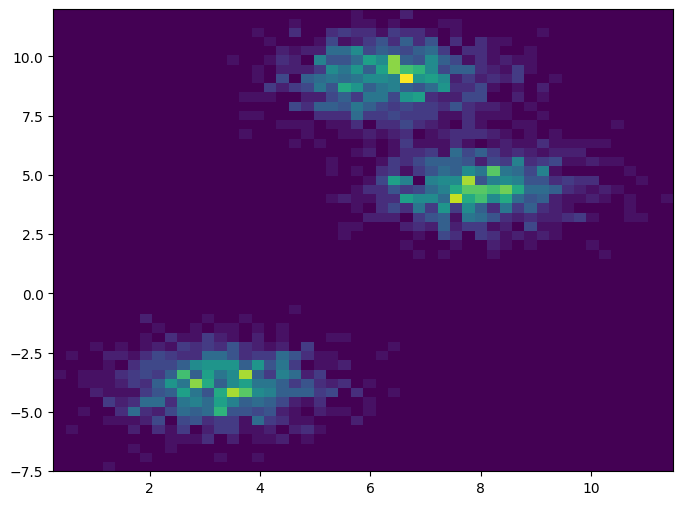

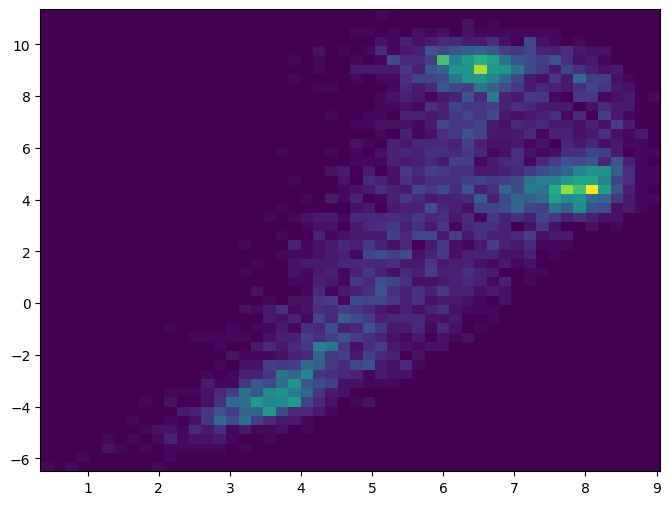

In [18]:
train_dataset, test_dataset = gauss_clusters(number_clusters=3, number_samples=5000, vector_size=25)
for hidden_dim in hidden_dim_params:
    print(f'hidden_dim = {hidden_dim}')
    model = VAE(latent_dim=10, input_dim=25, hidden_dim=hidden_dim)
    model.to(device)
    writer = SummaryWriter(log_dir = f'tensorboard4/hidden_dim_{hidden_dim}')
    call = callback(writer, test_dataset, loss_function)
    check_model(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100,
        batch_size=64,
        dataset=train_dataset,
        model=model,
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check_model(64, test_dataset, model, loss_function)

## Выводы

По получившимся картинкам можно сказать, что в целом все модели так или иначе справились с задачей. При маленькой размерности скрытого пространства модель восстанавливает только центры гауссиан (точки располагаются плотно). При маленьком размере слоя нейросети модель восстанавливает центр только одного из трёх кластеров с сохранением направления на остальные два.

По графикам tensorboard видно, что размер слоя нейросети действительно лучше брать большим. Размеры скрытого и исходного представления лучше взять равными. Например, при фиксированном размере скрытого представления 10 наименьший loss на train был у модели с размерностью исходного пространства 10. Аналогично при фиксированной исходной размерности 25 лучше всего скрытая размерность 25.

По внешнему виду картинок (предсказаний на test) модель 10/10 мне нравится больше, чем 25/25. Хотя по графикам tensorboard именно на test результат лучше у модели 25/25, а на train - наоборот. В любом случае, модели по умолчанию обучались с макисмальным размером слоя нейросети 1000. То есть собирать лучшую модель из подобранных параметров не нужно - это либо модель 25/25 (перебор latent_dim при input_dim = 25, первый эксперимент), либо модель 10/10 (перебор input_dim при latent_dim = 10, второй эксперимент).